In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline
import matplotlib.pyplot as plt
from arch import arch_model
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
import arch 
import warnings
warnings.filterwarnings('ignore')

# Return Forecasting: Read Historical Daily Yen Futures Data
In this notebook, you will load historical Dollar-Yen exchange rate futures data and apply time series analysis and modeling to determine whether there is any predictable behavior.

In [2]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
yen_futures = pd.read_csv(
    Path("yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


In [3]:
# Trim the dataset to begin on January 1st, 1990
yen_futures = yen_futures.loc["1990-01-01":, :]
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336.0,51473.0
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206.0,53860.0
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0


 # Return Forecasting: Initial Time-Series Plotting

 Start by plotting the "Settle" price. Do you see any patterns, long-term and/or short?

<AxesSubplot:xlabel='Date'>

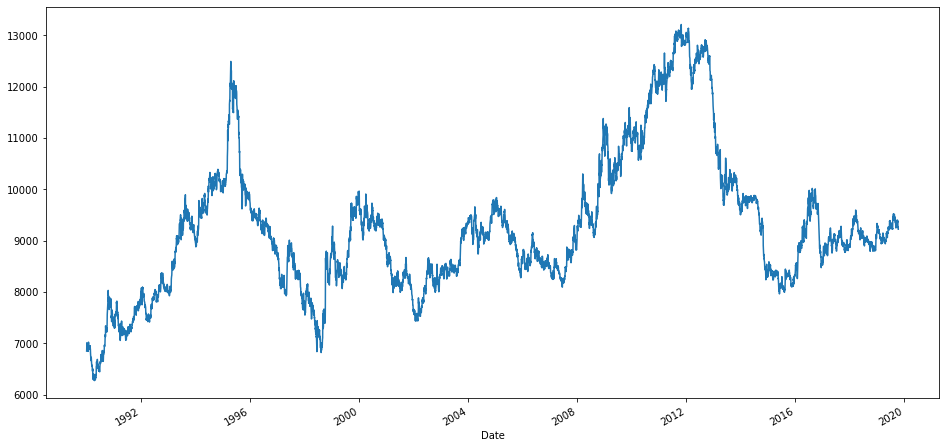

In [4]:
# Plot just the "Settle" column from the dataframe:
yen_futures.Settle.plot(figsize=(16,8))

---

# Decomposition Using a Hodrick-Prescott Filter

 Using a Hodrick-Prescott Filter, decompose the Settle price into a trend and noise.

In [5]:
# Apply the Hodrick-Prescott Filter by decomposing the "Settle" price into two separate series:
noise,trend = sm.tsa.filters.hpfilter(yen_futures.Settle)

In [6]:
# Create a dataframe of just the settle price, and add columns for "noise" and "trend" series from above:
settle_price_df = pd.DataFrame( yen_futures['Settle'])
settle_price_df['noise'] = noise
settle_price_df['trend'] = trend
settle_price_df

,Settle,noise,trend
Date,,,
1990-01-02,6847.0,-61.503967,6908.503967
1990-01-03,6887.0,-21.799756,6908.799756
1990-01-04,7008.0,98.942896,6909.057104
1990-01-05,6950.0,40.776052,6909.223948
1990-01-08,6959.0,49.689938,6909.310062
...,...,...,...
2019-10-09,9338.0,24.939247,9313.060753
2019-10-10,9303.5,-5.868559,9309.368559
2019-10-11,9251.0,-54.454594,9305.454594


<AxesSubplot:title={'center':'Settle vs. Trend'}, xlabel='Date'>

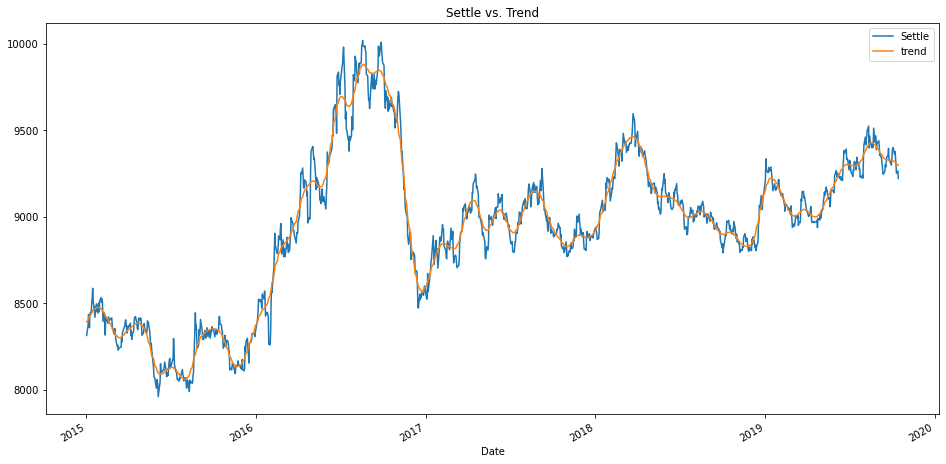

In [7]:
# Plot the Settle Price vs. the Trend for 2015 to the present
settle_price_df.loc['2015':'2021'][['Settle','trend']].plot( title = 'Settle vs. Trend',figsize=(16,8))

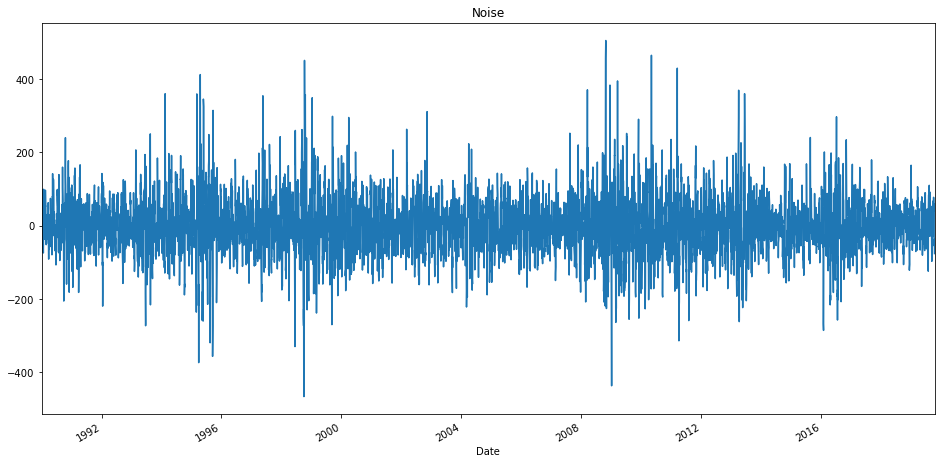

In [8]:
# Plot the Settle Noise
settle_price_df['noise'].plot( title = 'Noise',figsize=(16,8))
plt.margins(x = 0)

---

# Forecasting Returns using an ARMA Model

Using futures Settle *Returns*, estimate an ARMA model

1. ARMA: Create an ARMA model and fit it to the returns data. Note: Set the AR and MA ("p" and "q") parameters to p=2 and q=1: order=(2, 1).
2. Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the forecasted returns (the results forecast from ARMA model)

In [9]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
# Multiply the pct_change() results by 100 in order to get percentages
# Replace inf, -inf values with np.nan"s
returns = (yen_futures[["Settle"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()

,Settle
Date,
2019-10-09,-0.410601
2019-10-10,-0.369458
2019-10-11,-0.564304
2019-10-14,0.151335
2019-10-15,-0.469509


In [10]:
import statsmodels.api as sm

# Estimate and ARMA model using statsmodels using order=(2, 1)
arma_model=ARMA(returns.Settle.values, order=(2,1))

# Fit the model and assign it to a variable called results
result21 = arma_model.fit()

In [11]:
# Output model summary results:
result21.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 7514
Model:                     ARMA(2, 1)   Log Likelihood               -7894.071
Method:                       css-mle   S.D. of innovations              0.692
Date:                Tue, 26 Oct 2021   AIC                          15798.142
Time:                        17:25:29   BIC                          15832.765
Sample:                             0   HQIC                         15810.030
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0063      0.008      0.804      0.422      -0.009       0.022
ar.L1.y       -0.3062      1.277     -0.240      0.811      -2.810       2.197
ar.L2.y       -0.0019      0.019     -0.099      0.921      -0.040       0.036
ma.L1.y        0.2946      1.277      0.231      0.818      -2.209       2.798
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -3.3353           +0.0000j            3.3353            0.5000
AR.2         -157.2097           +0.0000j          157.2097            0.5000
MA.1           -3.3942           +0.0000j            3.3942            0.5000
-----------------------------------------------------------------------------
"""

## Conclusion
#### In the above ARMA model, the autoregressive term has a p-value (.422) that is greater than 0.05(significance level). We can conclude that the coefficient for the autoregressive model is not statistically significant and should not be kept in the model.


<AxesSubplot:title={'center':'ARMA Forecast Return'}>

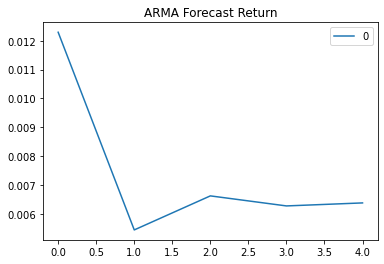

In [12]:
# Plot the 5 Day Returns Forecast
pd.DataFrame(result21.forecast(steps = 5)[0]).plot(title = "ARMA Forecast Return")

---

# Forecasting the Settle Price using an ARIMA Model

 1. Using the *raw* Yen **Settle Price**, estimate an ARIMA model.
     1. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
 2. Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
 3. Construct a 5 day forecast for the Settle Price. What does the model forecast will happen to the Japanese Yen in the near term?

In [13]:
from statsmodels.tsa.arima_model import ARIMA

# Estimate and ARIMA Model:
# ARIMA using order=(p, d, q) as (5,1,1)
arima_model = ARIMA(returns.Settle.values, order = (5,1,1))

# Fit the model
result511 = arima_model.fit()

In [14]:
# Output model summary results:
result511.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                 7513
Model:                 ARIMA(5, 1, 1)   Log Likelihood               -7895.604
Method:                       css-mle   S.D. of innovations              0.692
Date:                Tue, 26 Oct 2021   AIC                          15807.208
Time:                        17:25:38   BIC                          15862.603
Sample:                             1   HQIC                         15826.229
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.213e-06   3.59e-06     -0.895      0.371   -1.02e-05    3.82e-06
ar.L1.D.y     -0.0118      0.012     -1.027      0.304      -0.034       0.011
ar.L2.D.y     -0.0005      0.012     -0.040      0.968      -0.023       0.022
ar.L3.D.y     -0.0130      0.012     -1.125      0.261      -0.036       0.010
ar.L4.D.y     -0.0194      0.012     -1.677      0.094      -0.042       0.003
ar.L5.D.y     -0.0022      0.012     -0.193      0.847      -0.025       0.020
ma.L1.D.y     -0.9999      0.000  -2423.738      0.000      -1.001      -0.999
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.7478           -1.7610j            2.4811           -0.1256
AR.2            1.7478           +1.7610j            2.4811            0.1256
AR.3           -2.0592           -2.1916j            3.0072           -0.3700
AR.4           -2.0592           +2.1916j            3.0072            0.3700
AR.5           -8.0466           -0.0000j            8.0466           -0.5000
MA.1            1.0001           +0.0000j            1.0001            0.0000
-----------------------------------------------------------------------------
"""

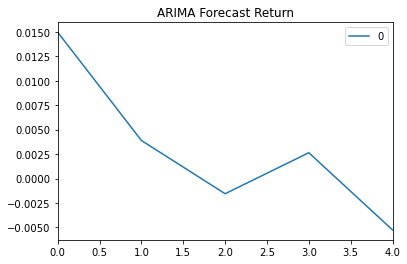

In [15]:
# Plot the 5 Day Price Forecast
pd.DataFrame(result511.forecast(steps = 5)[0]).plot(title = 'ARIMA Forecast Return')
plt.margins(x = 0)

---

# Volatility Forecasting with GARCH

Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen futures returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.
 
Using futures Settle *Returns*, estimate an GARCH model

1. GARCH: Create an GARCH model and fit it to the returns data. Note: Set the parameters to p=2 and q=1: order=(2, 1).
2. Output the GARCH summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the volatility.

In [17]:
# Estimate a GARCH model:
arch_model = arch_model(returns, vol="GARCH", p=1, q=1)

# Fit the model
garch_result = arch_model.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 140258354.12915346
Iteration:      2,   Func. Count:     16,   Neg. LLF: 7907.636233071084
Iteration:      3,   Func. Count:     22,   Neg. LLF: 7500.143839856692
Iteration:      4,   Func. Count:     28,   Neg. LLF: 7526.088204768028
Iteration:      5,   Func. Count:     34,   Neg. LLF: 7507.612498827388
Iteration:      6,   Func. Count:     40,   Neg. LLF: 7492.024503747673
Iteration:      7,   Func. Count:     46,   Neg. LLF: 7502.103117843514
Iteration:      8,   Func. Count:     52,   Neg. LLF: 12524.029685569323
Iteration:      9,   Func. Count:     59,   Neg. LLF: 7462.625090840102
Iteration:     10,   Func. Count:     65,   Neg. LLF: 7462.266426861943
Iteration:     11,   Func. Count:     71,   Neg. LLF: 7461.918918403824
Iteration:     12,   Func. Count:     76,   Neg. LLF: 7461.918909335227
Iteration:     13,   Func. Count:     80,   Neg. LLF: 7461.91890933325
Optimization terminated successfully    (Exit mode 0)
         

In [18]:
# Summarize the model results
garch_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                 Settle   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7461.92
Distribution:                  Normal   AIC:                           14931.8
Method:            Maximum Likelihood   BIC:                           14959.5
                                        No. Observations:                 7514
Date:                Tue, Oct 26 2021   Df Residuals:                     7513
Time:                        17:25:40   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         9.3848e-04  7.382e-03      0.127      0.899 [-1.353e-02,1.541e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      4.2848e-03  1.799e-03      2.382  1.722e-02 [7.592e-04,7.810e-03]
alpha[1]       0.0381  8.785e-03      4.332  1.478e-05 [2.084e-02,5.527e-02]
beta[1]        0.9536  1.115e-02     85.491      0.000     [  0.932,  0.976]
============================================================================

Covariance estimator: robust
"""

In [19]:
# Find the last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

'2019-10-15'

In [20]:
# Create a 5 day forecast of volatility
forecast_horizon = 5
# Start the forecast using the last_day calculated above
forecasts = garch_result.forecast(start = last_day, horizon = 5)

In [21]:
# Annualize the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate.head()

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2019-10-15,7.435446,7.477073,7.518126,7.558619,7.598562


In [22]:
# Transpose the forecast so that it is easier to plot
final = intermediate.dropna().T
final.head()

Date,2019-10-15
h.1,7.435446
h.2,7.477073
h.3,7.518126
h.4,7.558619
h.5,7.598562


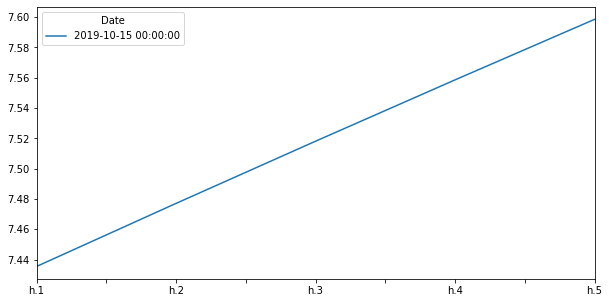

In [23]:
# Plot the final forecast
final.plot(figsize=(10,5))
plt.margins(x = 0)

---

# Conclusions

Based on your time series analysis, would you buy the yen now?
Being risk aware I would not by the Yen at the moment. The upward trending GARCH Model predicts that exchange rate risk is expected to increase and I am not comfortable with this level of risk.

Based on the model evaluation, would you feel confident in using these models for trading?
Lot needs to improve on this model for me to bet my money on these predictions. A good model need to have statiscally significant P-Values which is not the case in the model above.